# Подготовка данных для модели

In [5]:
!git clone https://github.com/Nazar1997/Sparse_vector

Cloning into 'Sparse_vector'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 81 (delta 37), reused 62 (delta 18), pack-reused 0
Unpacking objects: 100% (81/81), 17.52 KiB | 717.00 KiB/s, done.


In [6]:
import pandas as pd
import numpy as np
import scipy
from tqdm import trange
from tqdm.notebook import tqdm
import sys
import os
import seaborn as sns
from matplotlib import pyplot as plt
from joblib import Parallel, delayed, dump, load
from matplotlib import pyplot as plt
from Sparse_vector.sparse_vector import SparseVector

# Модель

In [2]:
import torch
from torch.utils import data
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold

In [1]:
!wget https://raw.githubusercontent.com/xen234/cancer-genome-breakpoints-prediction/main/data/model_data/lungs.peaks.csv

--2023-05-22 19:51:58--  https://raw.githubusercontent.com/xen234/cancer-genome-breakpoints-prediction/main/data/model_data/lungs.peaks.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110381 (108K) [text/plain]
Saving to: ‘lungs.peaks.csv’

lungs.peaks.csv     100%[===================>] 107.79K  --.-KB/s    in 0.02s   

2023-05-22 19:51:59 (5.13 MB/s) - ‘lungs.peaks.csv’ saved [110381/110381]



In [8]:
features = pd.read_csv('lungs.peaks.csv')
features

,chr,chr_bkpt,peak,mark,is_bkpt
0,chr7,138537319,85,Histone_H3K27ac,1
1,chr7,138545823,502,Histone_H3K36me3,1
2,chr7,138545823,198,Histone_H3K27me3,1
3,chr7,138540382,158,TFs_and_others_ASCL1,1
4,chr7,138539930,110,Histone_H3K27ac,1
...,...,...,...,...,...
2826,chr3,143906730,139,Histone_H3.3,0
2827,chr3,143906730,204,TFs_and_others_STAG1,0
2828,chr13,96744556,317,TFs_and_others_EZH2,0
2829,chr13,96744556,820,Histone_H3K4me3,0


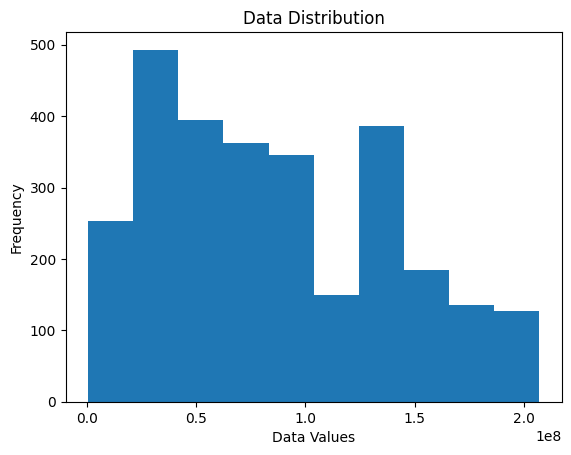

In [9]:
import matplotlib.pyplot as plt

# Assuming your data is stored in a variable called 'data'
plt.hist(features['chr_bkpt'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Data Values')
plt.ylabel('Frequency')
plt.title('Data Distribution')
plt.show()

In [215]:
features.drop(['is_bkpt', 'chr', 'mark', 'peak'], axis=1).drop_duplicates()

,chr_bkpt,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51
0,138539032,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,138537319,85,85,85,85,85,85,85,85,85,...,85,85,85,85,85,85,85,85,85,85
22,138545823,0,0,0,254,254,254,254,254,254,...,502,502,502,502,502,502,502,502,502,502
23,138545823,180,180,180,180,180,180,180,180,180,...,198,198,198,198,198,198,198,198,198,198
24,138540382,158,158,158,158,158,158,158,158,158,...,103,103,103,103,103,103,103,103,103,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18113,26267472,1561,1561,1561,1561,1561,1561,1561,1561,1561,...,1260,1260,1260,1260,1260,1260,1260,1260,1260,1260
18136,26267472,275,275,275,275,275,275,275,275,275,...,275,273,273,273,0,0,0,0,0,0
18150,26267472,243,243,243,243,243,243,243,243,243,...,0,0,0,0,0,0,0,0,0,0
18182,26267472,762,762,762,762,762,762,762,762,762,...,0,0,0,0,0,0,0,0,0,0


In [18]:
from torch import nn
import torch
from torch.utils import data
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


X = features.drop(['is_bkpt'], axis=1)
y = features['is_bkpt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42, shuffle=True)


label = LabelEncoder()
str_columns = ['chr', 'mark']
X_train[str_columns] = X_train[str_columns].apply(lambda x: label.fit_transform(x))
X_test[str_columns] = X_test[str_columns].apply(lambda x: label.fit_transform(x))

print(features.columns)
scaler = StandardScaler()
cols = ['peak', 'chr_bkpt']

X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])


params = {'batch_size':20,
          'num_workers':2,
          'shuffle':True}

X_train_array = X_train.values.astype(np.float32)
y_train_array = y_train.values.astype(np.float32)
X_val_array = X_test.values.astype(np.float32)
y_val_array = y_test.values.astype(np.float32)


train_dset = torch.utils.data.TensorDataset(torch.from_numpy(X_train_array).float(),
                                            torch.from_numpy(y_train_array).reshape(-1, 1).float())

val_dset = torch.utils.data.TensorDataset(torch.from_numpy(X_val_array).float(),
                                           torch.from_numpy(y_val_array).reshape(-1, 1).float())


train_loader = torch.utils.data.DataLoader(train_dset, **params)
val_loader = torch.utils.data.DataLoader(val_dset, **params)

Index(['chr', 'chr_bkpt', 'peak', 'mark', 'is_bkpt'], dtype='object')


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

print(y.unique())
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


[1 0]
Accuracy: 0.9074858757062146


In [22]:
import pandas as pd
from sklearn.linear_model import LinearRegression


model = LinearRegression()
model.fit(X_test, y_test)


coefficients = pd.Series(model.coef_, index=X.columns)
most_weighted_column = coefficients.idxmax()
print("Most weighted column:", most_weighted_column)

Most weighted column: chr
